In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# variable to be change according to the working environment
path = '/kaggle/input'

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-delays-fall-2018/sample_submission.csv.zip
/kaggle/input/flight-delays-fall-2018/flight_delays_train.csv.zip
/kaggle/input/flight-delays-fall-2018/flight_delays_test.csv.zip


## Import ...

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 

from sklearn.datasets import make_classification

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.calibration import CalibrationDisplay

from sklearn.pipeline import make_pipeline

import datetime
from datetime import timedelta
from datetime import time

## Load data from csv file in input folder

In [3]:
#df_train = pd.read_csv('/kaggle/input/flight-delays-fall-2018/flight_delays_train.csv.zip')
#df_test = pd.read_csv('/kaggle/input/flight-delays-fall-2018/flight_delays_test.csv.zip')
df_train = pd.read_csv(path + '/flight-delays-fall-2018/flight_delays_train.csv.zip')
df_test = pd.read_csv(path + '/flight-delays-fall-2018/flight_delays_test.csv.zip')

## pre treatment 

## Month, DayofMonth, DayOfWeek

### DepTime to date and time

In [4]:
def correct_date(x):
    if x['hour']>=24:
        x['date'] = x['date'] + timedelta(days=1)df_train = pre_treatment(df_train)
df_test = pre_treatment(df_test)
        x['hour'] = x['hour'] - 24
    return x

def pre_treatment(df):

    print (df.columns)
    
    # Add route
    df['route'] = df['Origin'] + '-' + df['Dest']

    # Month, DayofMonth, DayOfWeek
    cols = ['Month', 'DayofMonth', 'DayOfWeek']
    for col in cols:
        df[col+'-c'] = df[col].apply(lambda x: int(x.replace('c-', '')))

    # DepTime
    df['hour'] = df['DepTime'].apply(lambda x: x//100)
    df['minute'] = df['DepTime'].apply(lambda x:  x - 100 * (x//100) )

    # create date
    df['date'] = df.apply(lambda x: datetime.date(2018, x['Month-c'], x['DayofMonth-c']), axis=1)
    df = df.apply(lambda x: correct_date(x), axis=1)

    df['time'] = df.apply(
        lambda x: time(x['hour'], x['minute']), axis=1)
    df['datetime'] = df.apply(
        lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)

    df.sort_values(by=['datetime'], inplace=True)

    df['dep_day_carrier_count'] = df.groupby(by=['Origin', 'date', 'UniqueCarrier'])['Origin'].transform("count")
    df['dep_day_hour'] = df.groupby(by=['Origin', 'date', 'hour'])['Origin'].transform("count")
    df['dep_day_hour_carrier'] = df.groupby(by=['Origin', 'date', 'hour','UniqueCarrier'])['Origin'].transform("count")

    #pd.isna(df_train.groupby(by=['Origin', 'hour']).count().reset_index()['Dest'])

    #df['route_delay_count'] = df.groupby(by=['route', 'dep_delayed_15min'])['Origin'].transform('count')

    df['route_carrier_day_count'] = df.groupby(by=['route', 'UniqueCarrier', 'date'])['Origin'].transform('count')

    return df

In [5]:
df_train = pre_treatment(df_train)
df_test = pre_treatment(df_test)

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')
Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance'],
      dtype='object')


In [7]:
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,route,...,DayOfWeek-c,hour,minute,date,time,datetime,dep_day_carrier_count,dep_day_hour,dep_day_hour_carrier,route_carrier_day_count
34577,c-1,c-1,c-7,530,EV,OKC,ATL,761,N,OKC-ATL,...,7,5,30,2018-01-01,05:30:00,2018-01-01 05:30:00,1,1,1,1
44204,c-1,c-1,c-6,535,EV,CLE,ATL,554,N,CLE-ATL,...,6,5,35,2018-01-01,05:35:00,2018-01-01 05:35:00,1,1,1,1
73195,c-1,c-1,c-6,551,MQ,PIA,ORD,130,N,PIA-ORD,...,6,5,51,2018-01-01,05:51:00,2018-01-01 05:51:00,1,1,1,1
98736,c-1,c-1,c-7,553,MQ,MLI,ORD,139,N,MLI-ORD,...,7,5,53,2018-01-01,05:53:00,2018-01-01 05:53:00,1,1,1,1
55158,c-1,c-1,c-7,553,OO,AZO,ORD,122,N,AZO-ORD,...,7,5,53,2018-01-01,05:53:00,2018-01-01 05:53:00,1,1,1,1


## Label Encoder for UniqueCarrier Field

In [8]:
# Encode the object as an enumerated type or categorical variable.
# for col in ['Origin', 'Dest', 'UniqueCarrier']:
#    df_train[col] = pd.factorize(df_train[col])

carrier_le = preprocessing.LabelEncoder()
carrier_le.fit(pd.concat([df_train['UniqueCarrier'], df_test['UniqueCarrier']]))
df_train['UniqueCarrier-c'] = carrier_le.transform(df_train['UniqueCarrier'])
df_test['UniqueCarrier-c'] = carrier_le.transform(df_test['UniqueCarrier'])

## Label Encoder for Route

In [9]:
route_le = preprocessing.LabelEncoder()
route_le.fit(pd.concat([df_train['route'], df_test['route']]))
df_train['route-c'] = route_le.transform(df_train['route'])
df_test['route-c'] = route_le.transform(df_test['route'])

## Label Encoder for Dest and Orign Field

In [10]:
categ = ['Origin','Dest']
categf_target = ['Origin_C','Dest_C']
# Encode Categorical Columns
airport_le = preprocessing.LabelEncoder()
airport_le.fit(df_train['Origin'])
airport_le.fit(df_train['Dest'])
airport_le.fit(df_test['Origin'])
airport_le.fit(df_test['Dest'])
df_train[categf_target] = df_train[categ].apply(airport_le.fit_transform)
df_test[categf_target] = df_test[categ].apply(airport_le.fit_transform)

### Target column

In [12]:
dep_delayed_le = preprocessing.LabelEncoder()
dep_delayed_le.fit(df_train['dep_delayed_15min'])
df_train['target'] = dep_delayed_le.transform(df_train['dep_delayed_15min'])

## check imballance

In [20]:
df_train[['dep_delayed_15min']].value_counts()

dep_delayed_15min
N                    80956
Y                    19044
dtype: int64

In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

IndexError: single positional indexer is out-of-bounds

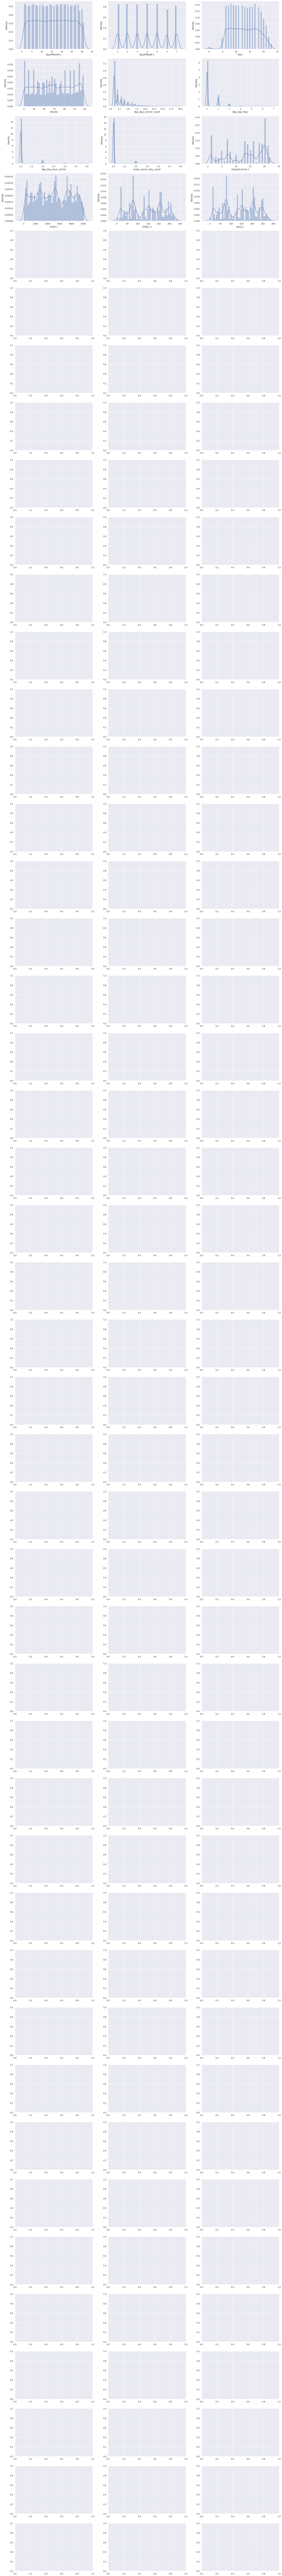

In [28]:
# Display the histogram 
fig,axes = plt.subplots(nrows=45,ncols=3,figsize=(25,250))

for i in range(2,137):
    sns.distplot(df_train[cols].iloc[:,i],ax=axes[(i-2)//3,(i-2)%3])

### Visualization of target distribution

<AxesSubplot:xlabel='target', ylabel='Count'>

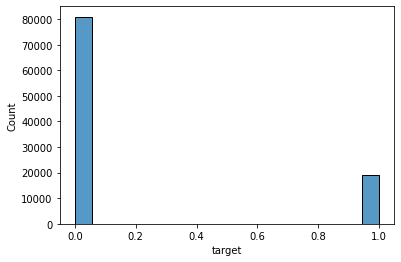

In [16]:
sns.histplot(df_train['target'])
#df_train['dep_delayed_15min-c'].hist()

In [17]:
cols = [
       'Distance', 'Month-c',
       'DayofMonth-c', 'DayOfWeek-c', 'hour', 'minute',       
       'dep_day_carrier_count', 'dep_day_hour',
       'dep_day_hour_carrier', 'route_carrier_day_count', 'UniqueCarrier-c',
       'route-c', 'Origin_C', 'Dest_C',
       ]

### Visualization of the correlation matrix

<AxesSubplot:>

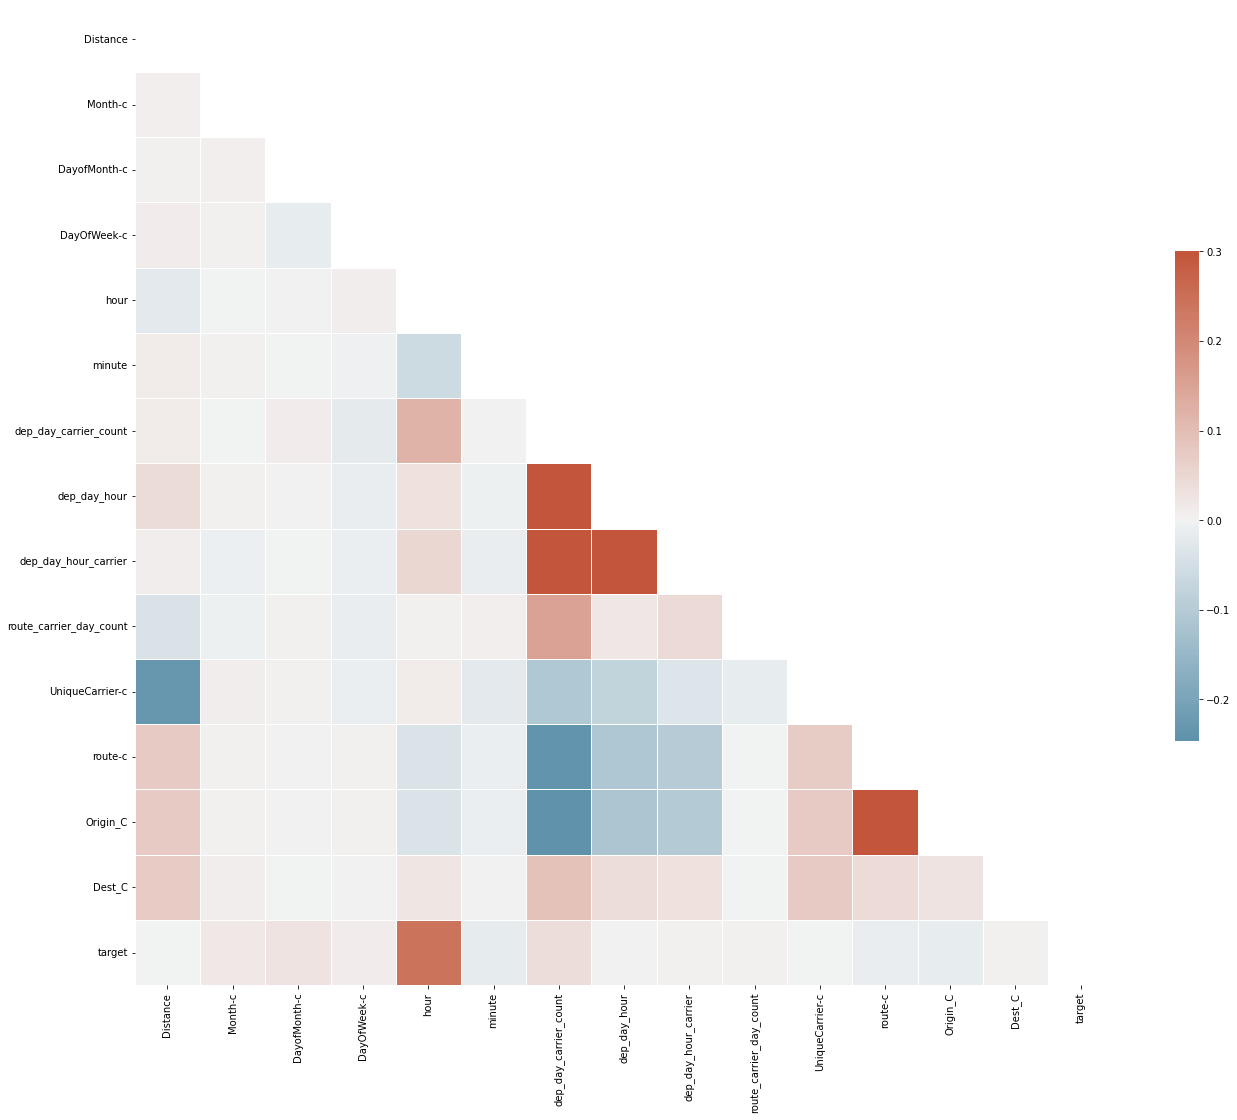

In [18]:
# Compute the correlation matrix
corr = df_train[[*cols, 'target']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Visualization of DayofMonth distribution

<AxesSubplot:xlabel='DayofMonth', ylabel='Count'>

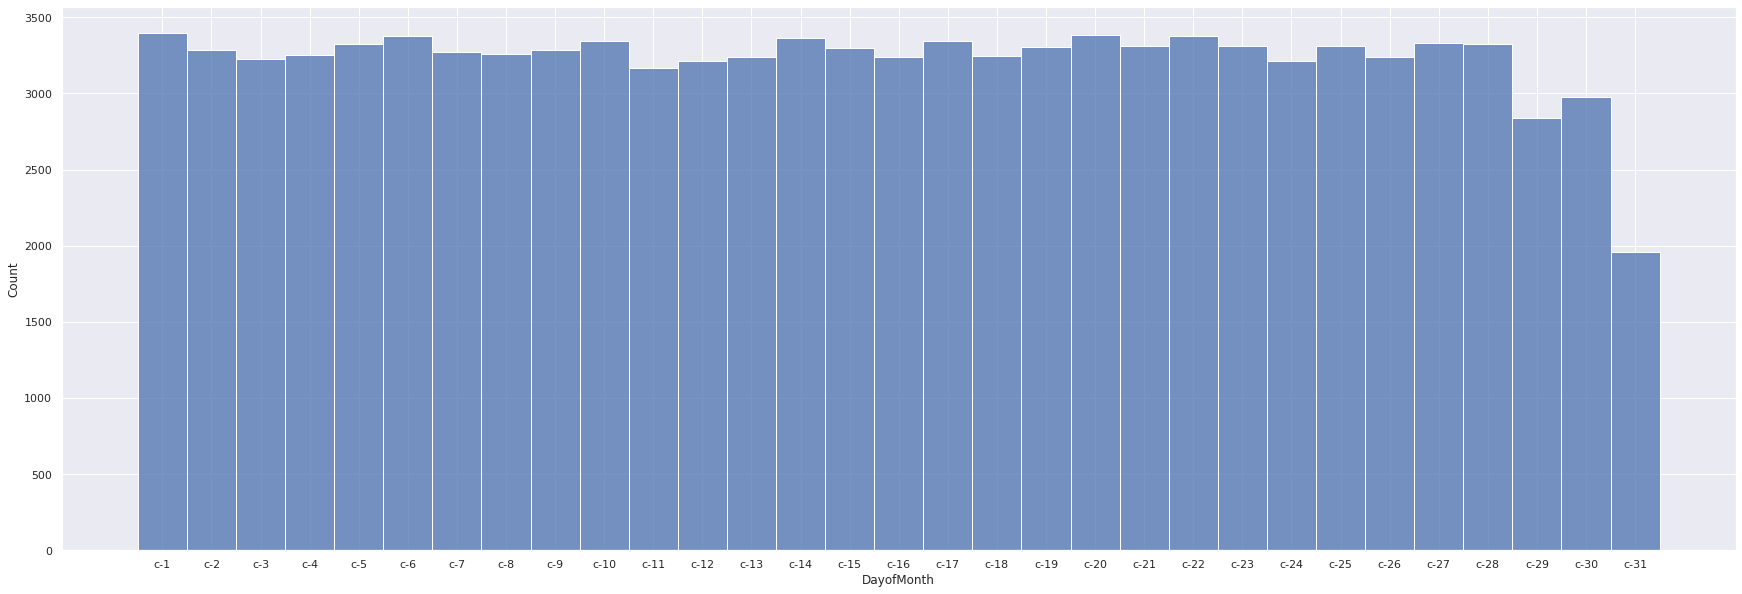

In [19]:
sns.set()
plt.figure(figsize=(30,10))
sns.histplot(df_train["DayofMonth"])

Visualization of DayOfWeek distribution

<AxesSubplot:xlabel='DayOfWeek', ylabel='Count'>

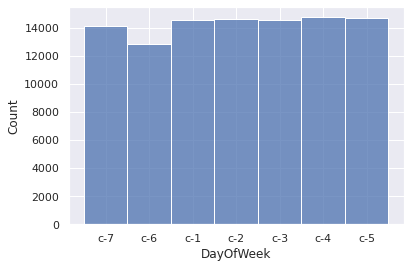

In [22]:
#df_train["DayOfWeek"].hist()
sns.histplot(df_train["DayOfWeek"])

### Visualization of Month distribution

<AxesSubplot:xlabel='Month', ylabel='Count'>

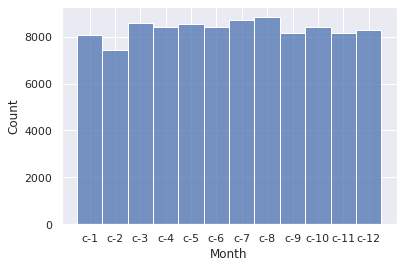

In [21]:
#df_train["Month"].hist()
sns.histplot(df_train["Month"])

Uniuqe carrier length 22


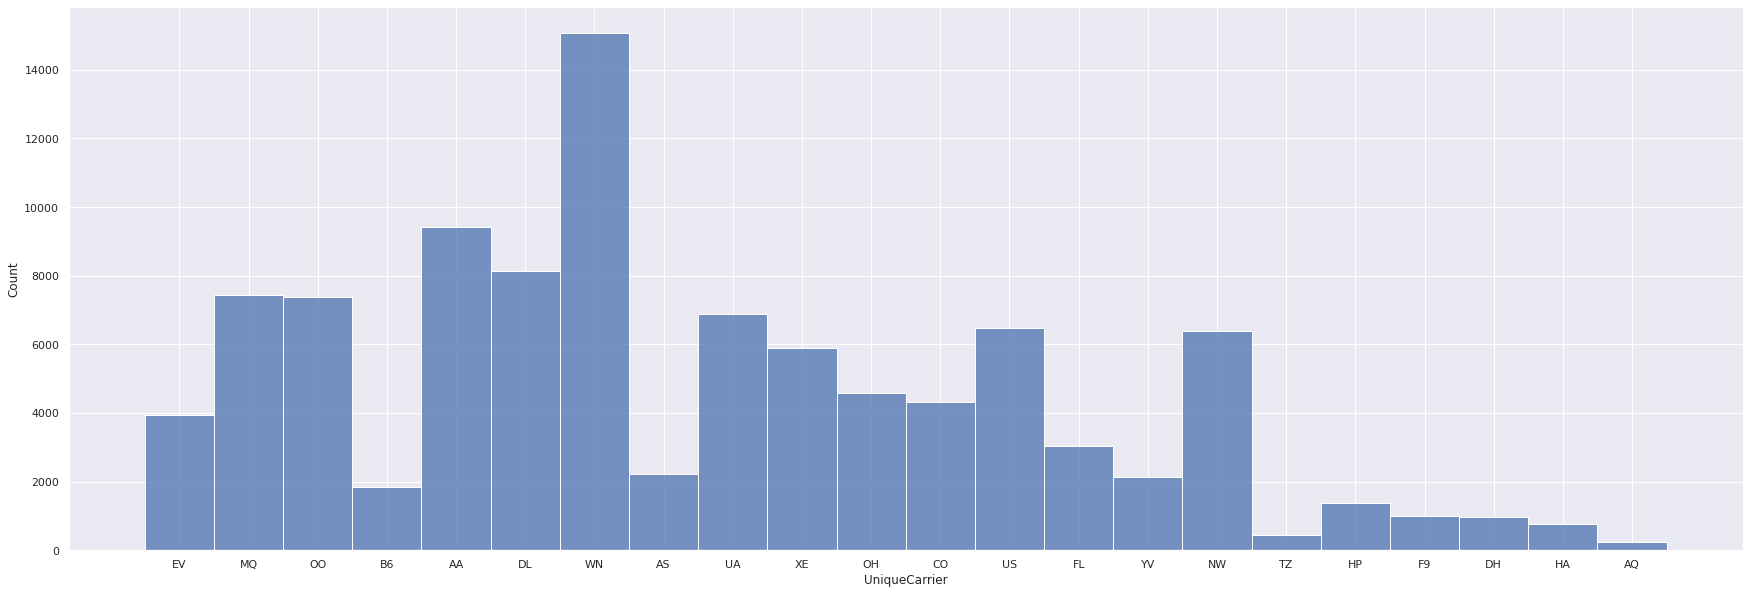

In [24]:
#df_train["UniqueCarrier"].hist()
plt.figure(figsize=(30,10))
sns.histplot(df_train["UniqueCarrier"])
print ('Uniuqe carrier length', len(df_train["UniqueCarrier"].unique()))

<AxesSubplot:xlabel='Distance', ylabel='Count'>

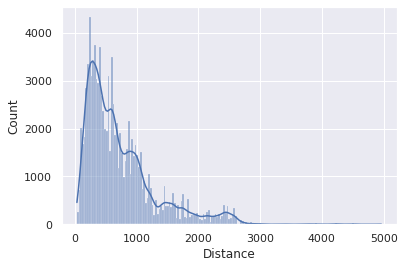

In [25]:
#sns.distplot(df_train["Distance"])
sns.histplot(df_train["Distance"],kde=True)

<AxesSubplot:xlabel='DepTime', ylabel='Count'>

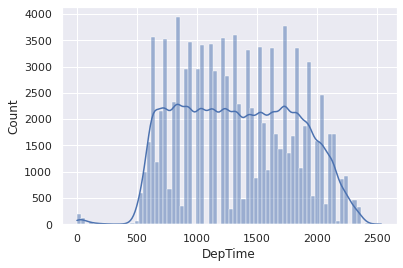

In [26]:
#sns.distplot(df_train["DepTime"])
sns.histplot(df_train["DepTime"] , kde=True)

### Treat imballance

In [29]:
# Class count
count_class_0, count_class_1 = df_train['target'].value_counts()

# Divide by class
df_class_0 = df_train[df_train['target'] == 0]
df_class_1 = df_train[df_train['target'] == 1]

In [30]:
df_class_1

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,route,...,dep_day_carrier_count,dep_day_hour,dep_day_hour_carrier,route_carrier_day_count,UniqueCarrier-c,route-c,Origin_C,Dest_C,dep_delayed_15min-c,target
98949,c-1,c-1,c-7,651,AS,SAN,SEA,1050,Y,SAN-SEA,...,1,2,1,1,3,4273,236,243,1,1
85029,c-1,c-1,c-6,815,OH,CVG,MDT,429,Y,CVG-MDT,...,6,1,1,1,15,1085,71,172,1,1
74781,c-1,c-1,c-7,822,UA,MCO,IAD,758,Y,MCO-IAD,...,1,1,1,1,18,2885,172,130,1,1
3173,c-1,c-1,c-7,918,MQ,BTR,DFW,383,Y,BTR-DFW,...,1,1,1,1,13,607,43,78,1,1
50783,c-1,c-1,c-6,925,AS,SFO,SEA,679,Y,SFO-SEA,...,1,1,1,1,3,4496,246,243,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21732,c-12,c-31,c-7,2241,AA,SFO,MIA,2585,Y,SFO-MIA,...,3,2,2,1,1,4475,246,180,1,1
38008,c-12,c-31,c-7,2247,AA,SFO,BOS,2704,Y,SFO-BOS,...,3,2,2,1,1,4446,246,35,1,1
57858,c-12,c-31,c-6,2250,OO,LAX,FAT,209,Y,LAX-FAT,...,2,2,2,1,16,2603,153,95,1,1
7536,c-12,c-31,c-7,2257,OO,LAX,PHX,370,Y,LAX-PHX,...,2,2,2,1,16,2639,153,211,1,1


### Under sampling

Random under-sampling:
0    19044
1    19044
Name: dep_delayed_15min-c, dtype: int64


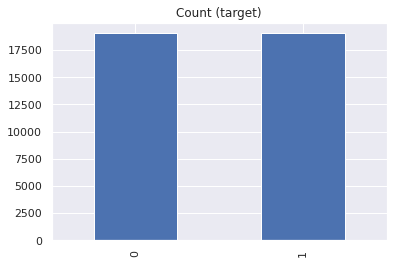

In [31]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['dep_delayed_15min-c'].value_counts())

df_test_under['dep_delayed_15min-c'].value_counts().plot(kind='bar', title='Count (target)');

In [33]:
### Clean pcolumns ...

X = df_test_under[cols]
Y = df_test_under['target']

df_test = df_test[cols]

## Model

## wrapper to launch model evaluation

Split of the dataset into train and test set will be done inside ;..


Standardize features by removing the mean and scaling to unit variance is also done in the wraping funtion -> !!!!! this should be done on the full dataset (train + test)


In [35]:
from sklearn import metrics

def evaluate_algo(X,Y, algo, n_splits=5):
    score = []
    final = []

    kfold = StratifiedKFold(n_splits=n_splits, random_state=24, shuffle=True)

    for Train, Test in kfold.split(X,Y):
        X_train, X_test = X.iloc[Train], X.iloc[Test]
        Y_train, Y_test = Y.iloc[Train], Y.iloc[Test]

        pipe = make_pipeline(StandardScaler(), algo)
        pipe.fit(X_train, Y_train)

        y_test_predict_proba = pipe.predict_proba(X_test)
        y_test_predict = pipe.predict(X_test)
        roc = roc_auc_score(Y_test, y_test_predict_proba[:,1])

        print(roc)
        score.append(roc)
        #final.append(y_test_predict[:,1])
        print (y_test_predict)
        print(metrics.classification_report(Y_test,y_test_predict))

    average_score = np.mean(score)
    print('The average roc is ', average_score)

## CatBoosClassifier

In [37]:
from catboost import CatBoostClassifier
#evaluate_algo(X, Y, CatBoostClassifier(iterations=10), n_splits=2)
print( 'without correct imballance')
evaluate_algo(X, Y, CatBoostClassifier(silent=True))
print( 'correct imballance')
evaluate_algo(df_train[cols], df_train['target'], CatBoostClassifier(silent=True))

without correct imballance
0.7350729549151286
[0 0 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      3809
           1       0.66      0.70      0.68      3809

    accuracy                           0.67      7618
   macro avg       0.67      0.67      0.67      7618
weighted avg       0.67      0.67      0.67      7618

0.7327519676250049
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      3809
           1       0.66      0.69      0.67      3809

    accuracy                           0.66      7618
   macro avg       0.66      0.66      0.66      7618
weighted avg       0.66      0.66      0.66      7618

0.739227214758044
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.69      0.62      0.65      3809
           1       0.66      0.72      0.68      3809

    accuracy                           0.67  

## Decision Tree

In [38]:
evaluate_algo(X, Y, DecisionTreeClassifier())

0.5857180362299816
[0 0 0 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      3809
           1       0.59      0.58      0.58      3809

    accuracy                           0.59      7618
   macro avg       0.59      0.59      0.59      7618
weighted avg       0.59      0.59      0.59      7618

0.5899186138093988
[1 1 1 ... 0 1 1]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      3809
           1       0.59      0.59      0.59      3809

    accuracy                           0.59      7618
   macro avg       0.59      0.59      0.59      7618
weighted avg       0.59      0.59      0.59      7618

0.5823050669467051
[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.58      0.59      0.58      3809
           1       0.58      0.58      0.58      3809

    accuracy                           0.58      7618
   macro avg     

## Test LogisticRegression

In [39]:
evaluate_algo(X, Y, LogisticRegression())

0.678132190406425
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3809
           1       0.62      0.65      0.63      3809

    accuracy                           0.63      7618
   macro avg       0.63      0.63      0.63      7618
weighted avg       0.63      0.63      0.63      7618

0.687382366217387
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      3809
           1       0.63      0.64      0.64      3809

    accuracy                           0.63      7618
   macro avg       0.63      0.63      0.63      7618
weighted avg       0.63      0.63      0.63      7618

0.68747631126925
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.64      0.61      0.62      3809
           1       0.63      0.66      0.64      3809

    accuracy                           0.63      7618
   macro avg       0.

# Test Random Forest

In [40]:
evaluate_algo(X, Y, RandomForestClassifier())

0.7229086559785273
[0 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      3809
           1       0.66      0.67      0.66      3809

    accuracy                           0.66      7618
   macro avg       0.66      0.66      0.66      7618
weighted avg       0.66      0.66      0.66      7618

0.7188625742419209
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      3809
           1       0.65      0.67      0.66      3809

    accuracy                           0.66      7618
   macro avg       0.66      0.66      0.66      7618
weighted avg       0.66      0.66      0.66      7618

0.7278122706298474
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.68      0.63      0.66      3809
           1       0.66      0.70      0.68      3809

    accuracy                           0.67      7618
   macro avg     

## Test Naive Bayes

In [42]:
evaluate_algo(X, Y, GaussianNB())

0.6702546600157522
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3809
           1       0.62      0.64      0.63      3809

    accuracy                           0.62      7618
   macro avg       0.62      0.62      0.62      7618
weighted avg       0.62      0.62      0.62      7618

0.6770564747612104
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      3809
           1       0.62      0.65      0.64      3809

    accuracy                           0.63      7618
   macro avg       0.63      0.63      0.63      7618
weighted avg       0.63      0.63      0.63      7618

0.6789621877024894
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.64      0.59      0.61      3809
           1       0.62      0.66      0.64      3809

    accuracy                           0.63      7618
   macro avg     

In [45]:
from sklearn.naive_bayes import MultinomialNB
#evaluate_algo(X, Y, MultinomialNB())
from sklearn.naive_bayes import ComplementNB
#evaluate_algo(X, Y, ComplementNB())

In [46]:
from sklearn.naive_bayes import BernoulliNB
evaluate_algo(X, Y, BernoulliNB())

0.639779278065016
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.62      0.63      0.63      3809
           1       0.63      0.62      0.62      3809

    accuracy                           0.62      7618
   macro avg       0.62      0.62      0.62      7618
weighted avg       0.62      0.62      0.62      7618

0.6428534110497163
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      3809
           1       0.63      0.61      0.62      3809

    accuracy                           0.63      7618
   macro avg       0.63      0.63      0.63      7618
weighted avg       0.63      0.63      0.63      7618

0.6498540750061982
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      3809
           1       0.64      0.63      0.63      3809

    accuracy                           0.63      7618
   macro avg      

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=0)
evaluate_algo(X, Y, gbc)

0.7133886724599219
[0 0 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      3809
           1       0.65      0.67      0.66      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7101123818544477
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      3809
           1       0.65      0.67      0.66      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7114957106812215
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      3809
           1       0.64      0.68      0.66      3809

    accuracy                           0.65      7618
   macro avg     

In [51]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
evaluate_algo(X, Y, clf)

0.7096693995739458
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      3809
           1       0.64      0.71      0.67      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7116228087557891
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      3809
           1       0.64      0.70      0.67      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7157207222451476
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      3809
           1       0.64      0.72      0.68      3809

    accuracy                           0.65      7618
   macro avg     

In [53]:
# Not tested
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
extra_tree = ExtraTreeClassifier(random_state=0)
cls = BaggingClassifier(extra_tree, random_state=0)
evaluate_algo(X, Y, clf)

0.7096693995739458
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.59      0.63      3809
           1       0.64      0.71      0.67      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7116228087557891
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63      3809
           1       0.64      0.70      0.67      3809

    accuracy                           0.65      7618
   macro avg       0.65      0.65      0.65      7618
weighted avg       0.65      0.65      0.65      7618

0.7157207222451476
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      3809
           1       0.64      0.72      0.68      3809

    accuracy                           0.65      7618
   macro avg     

In [55]:
# Not tested
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=100)
evaluate_algo(X, Y, clf)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.6882350399052803
[1 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      3809
           1       0.62      0.72      0.66      3809

    accuracy                           0.64      7618
   macro avg       0.64      0.64      0.63      7618
weighted avg       0.64      0.64      0.63      7618



/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.6938212208431744
[0 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.57      0.61      3809
           1       0.62      0.71      0.66      3809

    accuracy                           0.64      7618
   macro avg       0.64      0.64      0.64      7618
weighted avg       0.64      0.64      0.64      7618



/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.6936953634222632
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.68      0.53      0.60      3809
           1       0.62      0.74      0.67      3809

    accuracy                           0.64      7618
   macro avg       0.65      0.64      0.64      7618
weighted avg       0.65      0.64      0.64      7618



/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.6865182473619533
[0 1 0 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      3809
           1       0.62      0.72      0.66      3808

    accuracy                           0.64      7617
   macro avg       0.64      0.64      0.63      7617
weighted avg       0.64      0.64      0.63      7617

0.684376661533608
[0 0 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      3808
           1       0.62      0.70      0.66      3809

    accuracy                           0.63      7617
   macro avg       0.64      0.63      0.63      7617
weighted avg       0.64      0.63      0.63      7617

The average roc is  0.6893293066132559


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


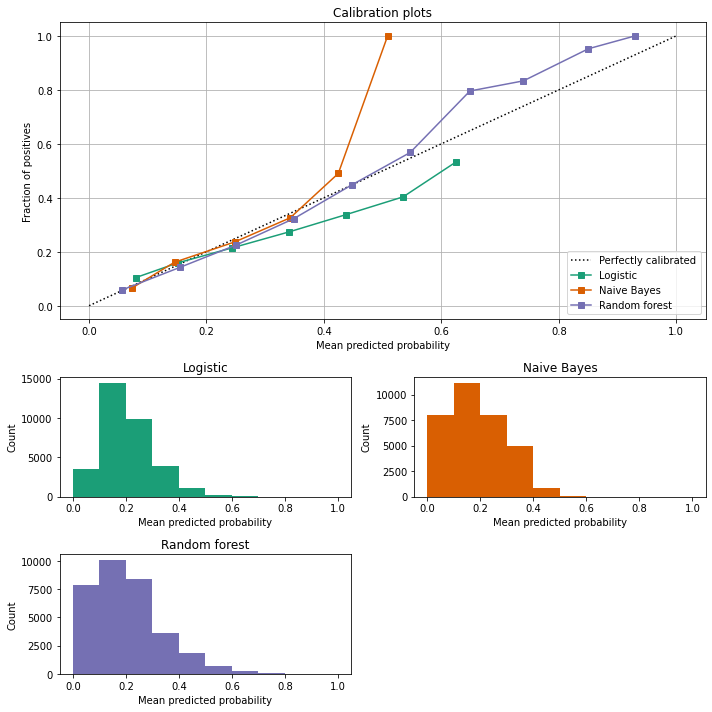

In [392]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Submission

### Submission sample data

In [59]:
df_submission = pd.read_csv(path + '/flight-delays-fall-2018/sample_submission.csv.zip')
df_submission.head()

,id,dep_delayed_15min
0,0,0.081
1,1,0.387
2,2,0.069
3,3,0.177
4,4,0.732


## Dataset to be predicted

In [61]:
pipe = make_pipeline(
    StandardScaler(),
    CatBoostClassifier(silent=True))
pipe.fit(df_train[cols], df_train['target'])

#pipe = make_pipeline(StandardScaler(), rfc)
#pipe.fit(X_train, y_train)
#prediction = pipe.predict_proba(df_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fb60da9e3d0>)])

In [62]:
df_test_submission = df_test[cols]
prediction = pipe.predict_proba(df_test_submission)
df_test_submission['dep_delayed_15min'] = prediction[:,1]
df_test_submission.head()

,Distance,Month-c,DayofMonth-c,DayOfWeek-c,hour,minute,dep_day_carrier_count,dep_day_hour,dep_day_hour_carrier,route_carrier_day_count,UniqueCarrier-c,route-c,Origin_C,Dest_C,dep_delayed_15min
98128,1635,1,1,1,0,21,1,1,1,1,5,4464,254,135,0.187532
77570,102,1,1,1,5,23,2,1,1,1,11,1988,129,163,0.016040
29503,640,1,1,1,6,0,2,1,1,1,13,941,64,38,0.057727
64570,589,1,1,1,6,4,1,1,1,1,18,2114,135,208,0.078160
73768,589,1,1,1,6,17,1,1,1,1,4,4632,262,162,0.110308


In [63]:
df_test_submission = df_test_submission[['dep_delayed_15min']].reset_index()
df_test_submission.columns = ['id', 'dep_delayed_15min']
df_test_submission.to_csv('./submission_catboost.csv', index=False)